In [5]:
"""
Association Navigation Analysis - Updated
Features:
- Image coordinate plotting (Top-Left Origin)
- Path length filtering
- Optional Q-Table calculation
"""
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from tqdm import tqdm

# ==========================================
# 1. DATA LOADING
# ==========================================

def load_data(data_dir):
    """Load all CSV files from the data directory"""
    csv_files = sorted(glob.glob(os.path.join(data_dir, "*.csv")))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    print(f"[INFO] Loading {len(csv_files)} CSV files...")
    dfs = []
    for f in tqdm(csv_files, desc="Loading data"):
        dfs.append(pd.read_csv(f))
    
    df = pd.concat(dfs, ignore_index=True)
    print(f"[INFO] Loaded {len(df)} total steps")
    return df


# ==========================================
# 2. REWARD PATH EXTRACTION
# ==========================================

def extract_successful_episodes(df):
    """Extract episodes that reached the reward"""
    # Group by episode
    episodes = df.groupby('episode')
    
    successful_episodes = []
    for ep_id, ep_data in episodes:
        # Check if episode contains reward
        if (ep_data['reward'] > 0).any():
            successful_episodes.append(ep_id)
    
    print(f"[INFO] Found {len(successful_episodes)} successful episodes")
    return successful_episodes


def get_episode_paths(df, episode_ids):
    """Get full paths for specified episodes"""
    paths = []
    
    for ep_id in episode_ids:
        ep_data = df[df['episode'] == ep_id].sort_values('step')
        
        # Extract trajectory
        path = {
            'episode': ep_id,
            'x': ep_data['x'].values,
            'y': ep_data['y'].values,
            'orientation': ep_data['orientation'].values,
            'actions': ep_data['action'].values,
            'ray_0': ep_data['ray_0'].values,
            'ray_1': ep_data['ray_1'].values,
            'ray_2': ep_data['ray_2'].values,
            'length': len(ep_data)
        }
        paths.append(path)
    
    return paths


# ==========================================
# 3. Q-TABLE CONSTRUCTION
# ==========================================

def discretize_state(ray_0, ray_1, ray_2):
    return (int(ray_0), int(ray_1), int(ray_2))


def build_qtable(df, successful_episodes):
    """
    Build Q-table from successful episodes
    """
    # Initialize Q-table as nested dict
    q_table = defaultdict(lambda: defaultdict(int))
    
    print("[INFO] Building Q-table from successful episodes...")
    
    for ep_id in tqdm(successful_episodes, desc="Processing episodes"):
        ep_data = df[df['episode'] == ep_id].sort_values('step')
        
        for idx, row in ep_data.iterrows():
            state = discretize_state(row['ray_0'], row['ray_1'], row['ray_2'])
            action = int(row['action'])
            q_table[state][action] += 1
    
    # Convert to regular dict
    q_table = {state: dict(actions) for state, actions in q_table.items()}
    print(f"[INFO] Q-table has {len(q_table)} unique states")
    return q_table


# ==========================================
# 4. VISUALIZATION
# ==========================================

def plot_successful_paths(paths, map_image_path, save_path, min_len=0, max_len=float('inf')):
    """
    Plot successful paths on the map using Image Coordinates.
    
    Args:
        min_len (int): Minimum path length to display
        max_len (int): Maximum path length to display
    """
    # Filter paths based on length
    filtered_paths = [p for p in paths if min_len <= p['length'] <= max_len]
    
    if not filtered_paths:
        print(f"[WARN] No paths found between length {min_len} and {max_len}")
        return

    # Load map
    map_img = cv2.imread(map_image_path, cv2.IMREAD_COLOR)
    if map_img is None:
        print(f"[WARN] Could not load map from {map_image_path}")
        map_img = np.ones((100, 100, 3), dtype=np.uint8) * 255
    
    map_img = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)
    h, w = map_img.shape[:2]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # IMAGES: Origin is UPPER LEFT (0,0 is top-left)
    ax.imshow(map_img, origin='upper') 
    
    # Plot each path
    colors = plt.cm.rainbow(np.linspace(0, 1, len(filtered_paths)))
    
    for path, color in zip(filtered_paths, colors):
        ax.plot(path['x'], path['y'], 
                color=color, alpha=0.6, linewidth=2)
        
        # Mark start and end
        ax.plot(path['x'][0], path['y'][0], 
                'go', markersize=6, markeredgecolor='black', label='Start' if path is filtered_paths[0] else "")
        ax.plot(path['x'][-1], path['y'][-1], 
                'r*', markersize=12, markeredgecolor='black', label='Goal' if path is filtered_paths[0] else "")
    
    # Image coordinates: Y axis increases downwards
    ax.set_ylim(h, 0)
    ax.set_xlim(0, w)
    
    ax.set_xlabel('X Position (Image Coords)')
    ax.set_ylabel('Y Position (Image Coords)')
    
    title_text = f'Successful Paths (n={len(filtered_paths)})'
    if min_len > 0 or max_len < float('inf'):
        title_text += f'\nFilter: Length [{min_len}, {max_len}]'
        
    ax.set_title(title_text)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"[INFO] Saved paths visualization to {save_path} (Count: {len(filtered_paths)})")


def plot_path_length_distribution(paths, save_path):
    """Plot histogram of path lengths"""
    if not paths:
        return {}
        
    lengths = [p['length'] for p in paths]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1.hist(lengths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(lengths), color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Path Length (steps)')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Path Lengths')
    
    # Box plot
    ax2.boxplot(lengths, vert=True)
    ax2.set_title('Path Length Statistics')
    
    stats = {
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'min': np.min(lengths),
        'max': np.max(lengths)
    }
    
    text_str = '\n'.join([f'{k}: {v:.1f}' for k,v in stats.items()])
    ax2.text(1.1, np.mean(lengths), text_str, 
             bbox=dict(facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    return stats


def plot_qtable_heatmap(q_table, save_path):
    """Visualize Q-table as heatmap"""
    # Count total visits per state
    state_counts = {state: sum(actions.values()) 
                    for state, actions in q_table.items()}
    
    sorted_states = sorted(state_counts.items(), 
                           key=lambda x: x[1], reverse=True)[:50]
    
    if not sorted_states:
        print("[WARN] Q-table is empty")
        return
    
    states = [s[0] for s in sorted_states]
    state_labels = [f"{s}" for s in states]
    
    matrix = np.zeros((len(states), 5))
    for i, state in enumerate(states):
        for action in range(5):
            if action in q_table[state]:
                matrix[i, action] = q_table[state][action]
    
    fig, ax = plt.subplots(figsize=(10, max(8, len(states) * 0.3)))
    im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto')
    
    ax.set_xticks(range(5))
    ax.set_xticklabels(['Up', 'Down', 'Left', 'Right', 'Nothing'])
    ax.set_yticks(range(len(states)))
    ax.set_yticklabels(state_labels, fontsize=8)
    
    plt.colorbar(im, ax=ax, label='Action Count')
    ax.set_title(f'Q-Table Heatmap (Top {len(states)} States)')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"[INFO] Saved Q-table heatmap to {save_path}")


# ==========================================
# 5. MAIN ANALYSIS
# ==========================================

def run_analysis():
    # --- CONFIGURATION ---
    DATA_DIR = "output/downsampled/2025-12-15-142024_100k_env12"
    MAP_PATH = "../environments/images/12.png"
    OUTPUT_DIR = os.path.join(DATA_DIR, "analysis")
    
    # New Config options
    BUILD_Q_TABLE = False          # Set to False to skip Q-table calculation
    PLOT_MIN_LEN = 100            # Min path length to plot
    PLOT_MAX_LEN = 300            # Max path length to plot
    
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print("="*60)
    print("ASSOCIATION NAVIGATION ANALYSIS")
    print("="*60)
    
    # 1. Load data
    try:
        df = load_data(DATA_DIR)
    except FileNotFoundError as e:
        print(e)
        return
    
    # 2. Extract successful episodes
    successful_eps = extract_successful_episodes(df)
    
    if len(successful_eps) == 0:
        print("[ERROR] No successful episodes found!")
        return
    
    # 3. Get paths
    paths = get_episode_paths(df, successful_eps)
    
    # 4. Build Q-table (Optional)
    q_table = None
    if BUILD_Q_TABLE:
        q_table = build_qtable(df, successful_eps)
    else:
        print("[INFO] Skipping Q-table generation (BUILD_Q_TABLE=False)")
    
    # 5. Visualizations
    print("\n[INFO] Generating visualizations...")
    
    # Plot paths with Filter and Image Coordinates
    plot_successful_paths(
        paths, MAP_PATH,
        os.path.join(OUTPUT_DIR, f"successful_paths_len_{PLOT_MIN_LEN}_{PLOT_MAX_LEN}.png"),
        min_len=PLOT_MIN_LEN,
        max_len=PLOT_MAX_LEN
    )
    
    # General stats (uses all paths)
    stats = plot_path_length_distribution(
        paths,
        os.path.join(OUTPUT_DIR, "path_length_distribution.png")
    )
    
    if BUILD_Q_TABLE and q_table:
        plot_qtable_heatmap(
            q_table,
            os.path.join(OUTPUT_DIR, "qtable_heatmap.png")
        )
        
        # Save Q-table for later use
        qtable_dict = {str(k): v for k, v in q_table.items()}
        with open(os.path.join(OUTPUT_DIR, "qtable.json"), 'w') as f:
            json.dump(qtable_dict, f, indent=2)
            
    print("\n" + "="*60)
    print("PATH LENGTH STATISTICS")
    print("="*60)
    for key, value in stats.items():
        print(f"{key.capitalize()}: {value:.2f}")
    
    print("\n" + "="*60)
    print(f"ANALYSIS COMPLETE")
    print(f"Results saved to: {OUTPUT_DIR}")
    print("="*60)


if __name__ == "__main__":
    run_analysis()

ASSOCIATION NAVIGATION ANALYSIS
[INFO] Loading 1000 CSV files...


Loading data: 100%|██████████| 1000/1000 [00:03<00:00, 268.32it/s]


[INFO] Loaded 100000 total steps
[INFO] Found 882 successful episodes
[INFO] Skipping Q-table generation (BUILD_Q_TABLE=False)

[INFO] Generating visualizations...
[INFO] Saved paths visualization to output/downsampled/2025-12-15-142024_100k_env12\analysis\successful_paths_len_100_300.png (Count: 363)

PATH LENGTH STATISTICS
Mean: 113.24
Median: 89.50
Min: 5.00
Max: 637.00

ANALYSIS COMPLETE
Results saved to: output/downsampled/2025-12-15-142024_100k_env12\analysis


# Analysis


## Imports 

In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from tqdm import tqdm

# --- CONFIGURATION ---
DATA_DIR = "output/downsampled/2025-12-15-142024_100k_env12"  # Check your timestamp!
MAP_PATH = "../environments/images/12.png"
OUTPUT_DIR = os.path.join(DATA_DIR, "analysis")

# Analysis Settings
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Analysis configured for: {DATA_DIR}")

Analysis configured for: output/downsampled/2025-12-15-142024_100k_env12


## Load Data

In [2]:
def load_data(data_dir):
    csv_files = sorted(glob.glob(os.path.join(data_dir, "*.csv")))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    print(f"[INFO] Loading {len(csv_files)} CSV files...")
    dfs = []
    for f in tqdm(csv_files, desc="Loading data"):
        dfs.append(pd.read_csv(f))
    
    df = pd.concat(dfs, ignore_index=True)
    print(f"[INFO] Loaded {len(df)} total steps")
    return df

# Run Loading
try:
    df = load_data(DATA_DIR)
except FileNotFoundError as e:
    print(e)

[INFO] Loading 1000 CSV files...


Loading data: 100%|██████████| 1000/1000 [00:02<00:00, 347.98it/s]


[INFO] Loaded 100000 total steps


In [3]:
df

,step,strategy,action,ray_0,ray_1,ray_2,episode,reward,x,y,orientation
0,0,random_uniform_5actions,2,2,2,2,1,0.0,5.00,15.00,345.79
1,1,random_uniform_5actions,0,2,2,2,1,0.0,9.85,13.77,345.79
2,2,random_uniform_5actions,3,2,2,2,1,0.0,9.85,13.77,0.79
3,3,random_uniform_5actions,2,2,2,2,1,0.0,9.85,13.77,345.79
4,4,random_uniform_5actions,4,2,2,2,1,0.0,9.85,13.77,345.79
...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,random_uniform_5actions,2,2,2,2,883,0.0,7.43,10.83,60.79
99996,99996,random_uniform_5actions,1,2,2,2,883,0.0,4.99,6.46,60.79
99997,99997,random_uniform_5actions,1,2,2,2,883,0.0,4.99,6.46,60.79
99998,99998,random_uniform_5actions,3,2,2,2,883,0.0,4.99,6.46,75.79


## Extract Successful Paths
This filters the massive dataframe down to just the episodes where the robot actually hit the goal.

In [4]:
def extract_successful_episodes(df):
    """Extract episodes that reached the reward"""
    episodes = df.groupby('episode')
    successful_episodes = []
    for ep_id, ep_data in episodes:
        if (ep_data['reward'] > 0).any():
            successful_episodes.append(ep_id)
    return successful_episodes

def get_episode_paths(df, episode_ids):
    """Get full trajectory data for successful episodes"""
    paths = []
    for ep_id in episode_ids:
        ep_data = df[df['episode'] == ep_id].sort_values('step')
        path = {
            'episode': ep_id,
            'x': ep_data['x'].values,
            'y': ep_data['y'].values,
            'length': len(ep_data),
            # Store other data only if needed for Q-table later
            'actions': ep_data['action'].values, 
            'ray_0': ep_data['ray_0'].values,
            'ray_1': ep_data['ray_1'].values,
            'ray_2': ep_data['ray_2'].values
        }
        paths.append(path)
    return paths

# Run Extraction
successful_eps = extract_successful_episodes(df)
paths = get_episode_paths(df, successful_eps)
print(f"[INFO] Found {len(successful_eps)} successful episodes")

[INFO] Found 882 successful episodes


## Path Length Statistics

In [13]:
# ==========================================
# 4. PATH LENGTH STATISTICS
# ==========================================

import numpy as np

if not paths:
    print("[WARN] No successful paths found to analyze.")
else:
    # Extract just the lengths
    lengths = [p['length'] for p in paths]

    print("=" * 60)
    print("PATH LENGTH STATISTICS")
    print("=" * 60)
    print(f"Mean:   {np.mean(lengths):.2f}")
    print(f"Median: {np.median(lengths):.2f}")
    print(f"Min:    {np.min(lengths):.2f}")
    print(f"Max:    {np.max(lengths):.2f}")
    print("=" * 60)

PATH LENGTH STATISTICS
Mean:   113.24
Median: 89.50
Min:    5.00
Max:    637.00


## Visualization (Path Plotting)
This uses Image Coordinates (Origin at Top-Left) and applies length filters.

In [6]:
# ------------------------------------------------------------
# Visualize successful paths over the map
# Notebook-style: edit values, rerun, observe
# ------------------------------------------------------------

# 1. Choose which paths you want to see
PLOT_MIN_LEN = 0
PLOT_MAX_LEN = 10000

print(f"Visualizing paths with length between {PLOT_MIN_LEN} and {PLOT_MAX_LEN}")

# Filter paths by length
filtered_paths = [
    p for p in paths
    if PLOT_MIN_LEN <= p['length'] <= PLOT_MAX_LEN
]

if not filtered_paths:
    print("No paths found in this length range.")
else:
    print(f"Found {len(filtered_paths)} paths")


filtered_paths[0]

Visualizing paths with length between 0 and 10000
Found 882 paths


{'episode': 1,
 'x': array([ 5.  ,  9.85,  9.85,  9.85,  9.85,  5.  ,  9.85,  5.  ,  5.  ,
         5.  ,  5.  ,  9.36,  9.36,  9.36,  9.36, 13.73, 13.73, 13.73,
        13.73,  9.36, 13.73, 13.73, 13.73, 13.73, 10.14, 13.73, 10.14,
        10.14, 10.14, 10.14, 10.14, 10.14, 10.14, 10.14, 10.14, 10.14,
         5.3 ,  5.3 , 10.14, 14.99, 10.14, 10.14,  5.3 ,  5.3 ,  5.3 ,
         5.3 ,  5.3 ,  5.3 ,  5.3 ,  5.3 ,  5.3 ,  5.3 ,  5.3 ,  5.3 ,
         5.3 ,  5.3 ,  5.3 ,  5.3 ,  5.3 ,  5.3 , 10.3 , 10.3 , 10.3 ,
        10.3 ,  5.3 ,  5.3 , 10.3 , 10.3 , 10.3 , 10.3 , 10.3 , 10.3 ,
        10.3 , 10.3 ,  6.  ,  6.  , 10.3 , 10.3 , 10.3 , 10.3 ,  5.49,
        10.3 , 10.3 , 10.3 , 10.3 ,  6.  ,  6.  ,  6.  , 10.3 , 10.3 ,
         6.  ,  6.  ,  6.  ,  9.49,  9.49,  9.49,  9.49,  9.49,  9.49,
         9.49,  9.49,  9.49,  9.49,  9.49,  9.49,  9.56,  9.63,  9.56,
         9.56,  9.56,  8.2 ,  9.56,  9.56, 10.92]),
 'y': array([15.  , 13.77, 13.77, 13.77, 13.77, 15.  , 13.77, 15.  , 15.  ,


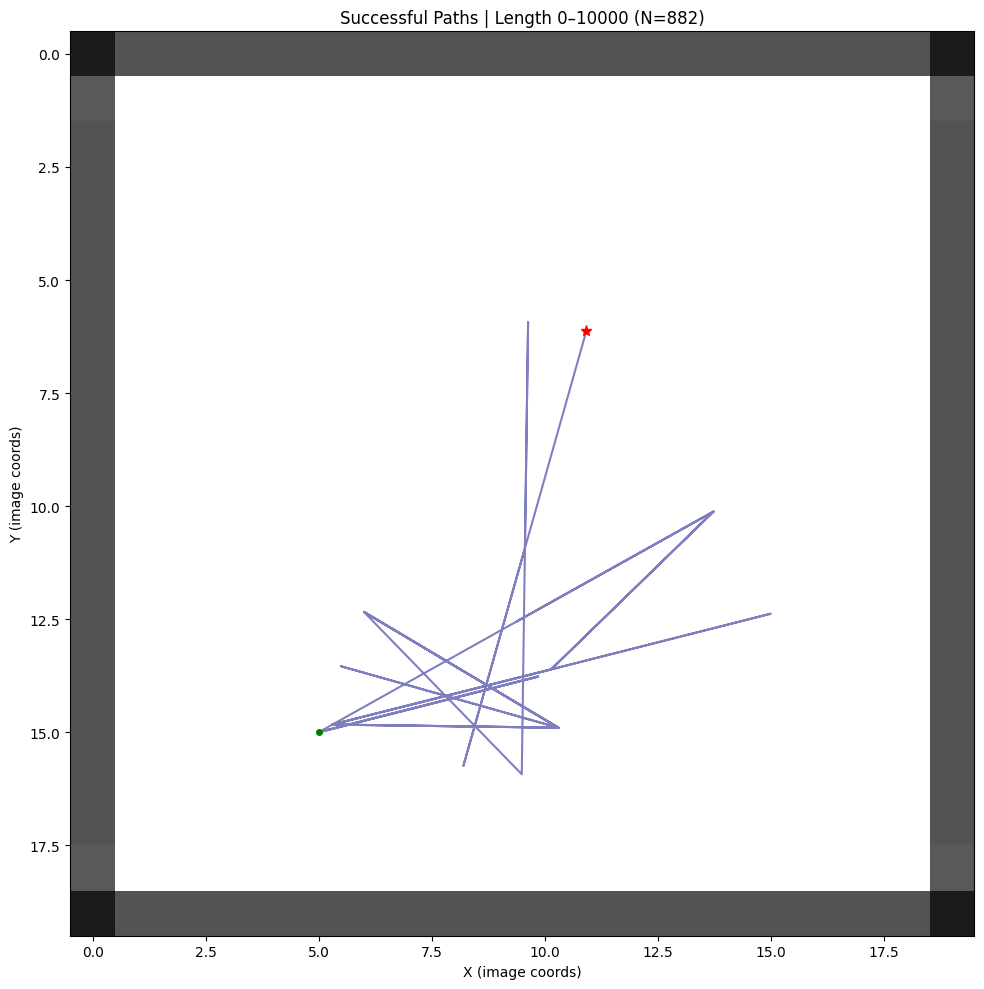

In [7]:
# ------------------------------------------------------------
# 2. Load the map (or fall back to blank canvas)
# ------------------------------------------------------------

map_img = cv2.imread(MAP_PATH, cv2.IMREAD_COLOR)

if map_img is None:
    print("Map not found — using white background")
    map_img = np.ones((100, 100, 3), dtype=np.uint8) * 255
else:
    # Convert BGR → RGB for matplotlib
    map_img = cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB)

h, w = map_img.shape[:2]

# ------------------------------------------------------------
# 3. Plot everything
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 10))

# origin='upper' so image coords match robot coords
ax.imshow(map_img, origin='upper')

# Color each path differently (purely for visual separation)
colors = plt.cm.jet(np.linspace(0, 1, len(filtered_paths[:1])))

for path, color in zip(filtered_paths, colors):
    x = path['x']
    y = path['y']

    # Full trajectory
    ax.plot(x, y, color=color, alpha=0.5, linewidth=1.5)

    # Start point
    ax.plot(x[0], y[0], 'go', markersize=4)

    # End point
    ax.plot(x[-1], y[-1], 'r*', markersize=8)

# ------------------------------------------------------------
# 4. Labels & framing
# ------------------------------------------------------------

ax.set_title(
    f"Successful Paths | Length {PLOT_MIN_LEN}–{PLOT_MAX_LEN} "
    f"(N={len(filtered_paths)})"
)
ax.set_xlabel("X (image coords)")
ax.set_ylabel("Y (image coords)")

plt.tight_layout()
plt.show()


## Q-table 

Building Q-Table...


Processing Paths: 100%|██████████| 882/882 [00:00<00:00, 1316.51it/s]


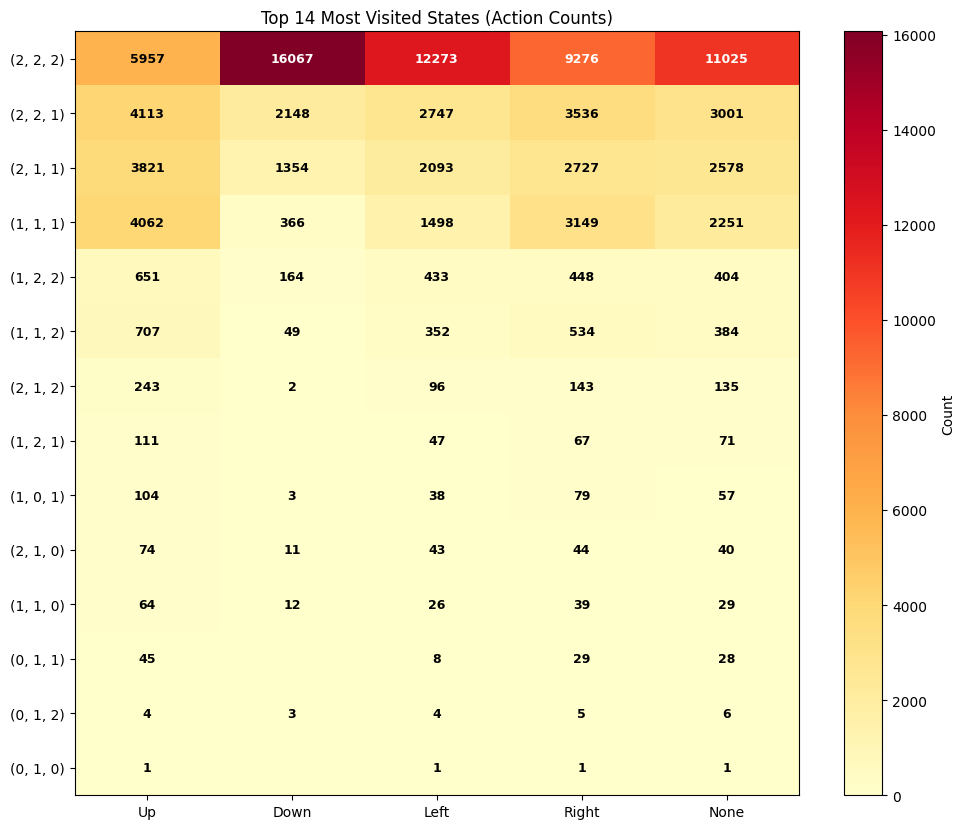

In [10]:
print("Building Q-Table...")
q_table = defaultdict(lambda: defaultdict(int))

# 1. Build the Table
for p in tqdm(paths, desc="Processing Paths"):
    for i in range(len(p['actions'])):
        state = (int(p['ray_0'][i]), int(p['ray_1'][i]), int(p['ray_2'][i]))
        action = int(p['actions'][i])
        q_table[state][action] += 1
        
# 2. Prepare Matrix for Top 20 States
# Sort states by total visits (descending)
states = sorted(q_table.keys(), key=lambda s: sum(q_table[s].values()), reverse=True)[:20]

# Create matrix: Rows=States, Cols=Actions (0-4)
matrix = np.zeros((len(states), 5))
for i, s in enumerate(states):
    for a in range(5):
        matrix[i, a] = q_table[s][a]
        
# 3. Plotting
fig, ax = plt.subplots(figsize=(10, max(6, len(states)*0.6)))
im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto')

# --- Loop to add numbers ---
for i in range(len(states)):
    for j in range(5):
        val = int(matrix[i, j])
        if val > 0:
            # Switch text to white if the background is too dark (high value)
            text_color = "white" if val > matrix.max() * 0.5 else "black"
            
            ax.text(j, i, str(val), 
                    ha="center", va="center", 
                    color=text_color, fontsize=9, fontweight='bold')
# ---------------------------

# Formatting
ax.set_yticks(range(len(states)))
ax.set_yticklabels([str(s) for s in states])

ax.set_xticks(range(5))
ax.set_xticklabels(['Up', 'Down', 'Left', 'Right', 'None'])

plt.colorbar(im, label='Count')
ax.set_title(f"Top {len(states)} Most Visited States (Action Counts)")
plt.tight_layout()
plt.show()


## Use Policy 

Evaluating Greedy:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating Stochastic: 100%|██████████| 1000/1000 [00:28<00:00, 35.22it/s]


PERFORMANCE SUMMARY


,Strategy,Success Rate,Mean Length,Median,Min,Max
0,Greedy,0.0,0.00,0.0,0,0
1,Stochastic,100.0,212.92,145.0,7,1784


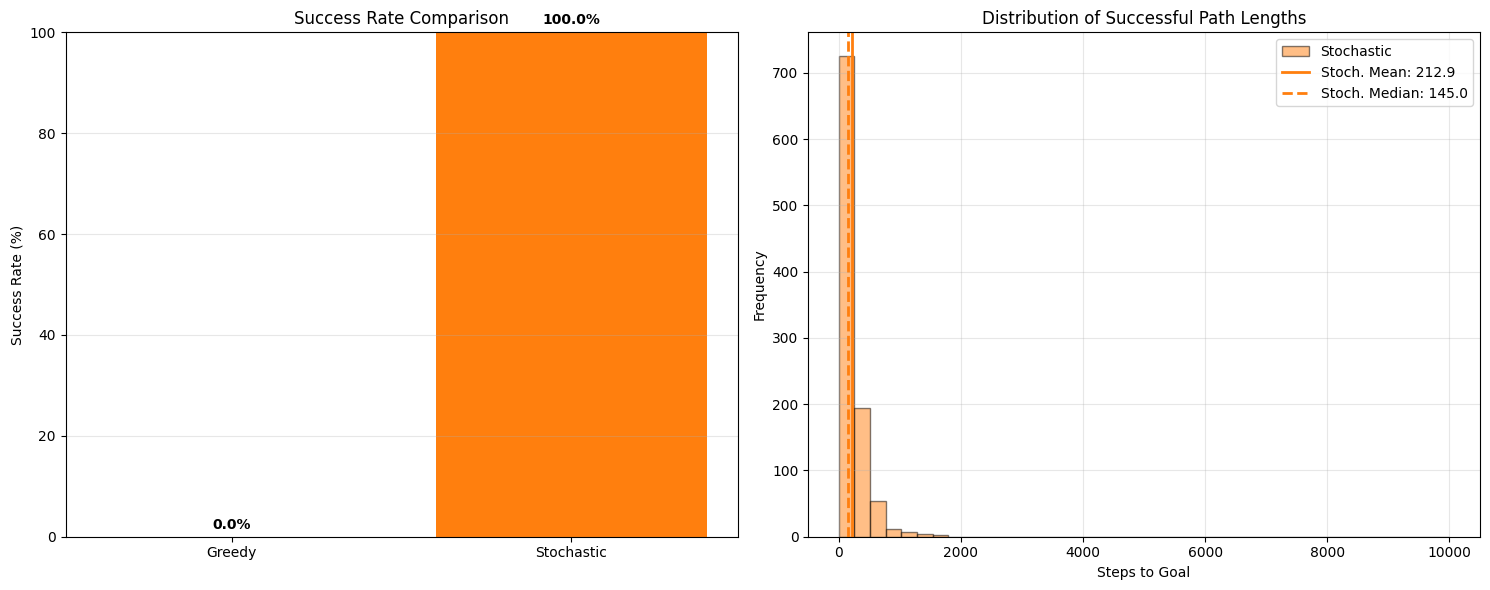

In [12]:
# ==========================================
# 7. Q-TABLE EVALUATION (GREEDY vs STOCHASTIC)
# ==========================================

from robot_env import DownsampledRobotEnv
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- CONFIGURATION ---
EVAL_EPISODES = 1_000       # 1k runs
MAX_STEPS = 10_000           # Max steps per episode
MAP_PATH = "../environments/images/12.png"

# --- HELPER FUNCTIONS ---

def get_action_greedy(state, q_table):
    """Returns the action with the highest count. Random if state unknown."""
    if state not in q_table:
        return random.randint(0, 4)
    
    actions = q_table[state]
    if not actions:
        return random.randint(0, 4)
        
    return max(actions.items(), key=lambda x: x[1])[0]

def get_action_stochastic(state, q_table):
    """Returns action based on probability distribution of counts."""
    if state not in q_table:
        return random.randint(0, 4)
        
    actions_dict = q_table[state]
    if not actions_dict:
        return random.randint(0, 4)
    
    actions = list(actions_dict.keys())
    counts = list(actions_dict.values())
    total = sum(counts)
    probs = [c / total for c in counts]
    
    return random.choices(actions, weights=probs, k=1)[0]

def run_evaluation(strategy_name, q_table, n_episodes):
    env = DownsampledRobotEnv(MAP_PATH, max_steps=MAX_STEPS, render_mode=False)
    
    success_lengths = []
    
    for ep in tqdm(range(n_episodes), desc=f"Evaluating {strategy_name}"):
        obs = env.reset()
        done = False
        
        while not done:
            state = tuple(int(x) for x in obs)
            
            if strategy_name == "Greedy":
                action = get_action_greedy(state, q_table)
            elif strategy_name == "Stochastic":
                action = get_action_stochastic(state, q_table)
            
            obs, reward, done, _ = env.step(action)
            
            if reward > 0: # Reached goal
                success_lengths.append(env.step_count)
                
    return success_lengths

# --- MAIN EXECUTION ---

if 'q_table' not in globals() or not q_table:
    print("[ERROR] Q-Table not found! Run the 'Q-Table Construction' cell first.")
else:
    # 1. Run Evaluations
    greedy_lengths = run_evaluation("Greedy", q_table, EVAL_EPISODES)
    stochastic_lengths = run_evaluation("Stochastic", q_table, EVAL_EPISODES)
    
    # 2. Compile Statistics
    def get_stats(name, lengths):
        if not lengths:
            return {"Strategy": name, "Success Rate": 0.0, "Mean Length": 0, "Median": 0, "Min": 0, "Max": 0}
        return {
            "Strategy": name,
            "Success Rate": (len(lengths) / EVAL_EPISODES) * 100,
            "Mean Length": np.mean(lengths),
            "Median": np.median(lengths),
            "Min": np.min(lengths),
            "Max": np.max(lengths)
        }

    stats = [
        get_stats("Greedy", greedy_lengths),
        get_stats("Stochastic", stochastic_lengths)
    ]
    
    df_results = pd.DataFrame(stats)
    
    # 3. Visualization
    print("\n" + "="*40)
    print("PERFORMANCE SUMMARY")
    print("="*40)
    display(df_results.round(2))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # A. Success Rate Bar Chart
    colors = {'Greedy': '#1f77b4', 'Stochastic': '#ff7f0e'}
    bars = ax1.bar(df_results["Strategy"], df_results["Success Rate"], 
                   color=[colors['Greedy'], colors['Stochastic']])
    ax1.set_ylabel("Success Rate (%)")
    ax1.set_title("Success Rate Comparison")
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

    # B. Path Length Histogram with Mean/Median
    bins = np.linspace(0, MAX_STEPS, 40)
    
    # Plot Greedy
    if greedy_lengths:
        ax2.hist(greedy_lengths, bins=bins, alpha=0.5, label='Greedy', color=colors['Greedy'], edgecolor='black')
        g_mean = np.mean(greedy_lengths)
        g_med = np.median(greedy_lengths)
        ax2.axvline(g_mean, color=colors['Greedy'], linestyle='-', linewidth=2, label=f'Greedy Mean: {g_mean:.1f}')
        ax2.axvline(g_med, color=colors['Greedy'], linestyle='--', linewidth=2, label=f'Greedy Median: {g_med:.1f}')

    # Plot Stochastic
    if stochastic_lengths:
        ax2.hist(stochastic_lengths, bins=bins, alpha=0.5, label='Stochastic', color=colors['Stochastic'], edgecolor='black')
        s_mean = np.mean(stochastic_lengths)
        s_med = np.median(stochastic_lengths)
        ax2.axvline(s_mean, color=colors['Stochastic'], linestyle='-', linewidth=2, label=f'Stoch. Mean: {s_mean:.1f}')
        ax2.axvline(s_med, color=colors['Stochastic'], linestyle='--', linewidth=2, label=f'Stoch. Median: {s_med:.1f}')
        
    ax2.set_xlabel("Steps to Goal")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Distribution of Successful Path Lengths")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()